Latrille Thibault

# Implémentation d'un double switch

Le notebook fonctionne sur python 2.7.x

## Gène (promoteur + ARN + protein)

Un gène est composé d'un promoteur actif ou inactif. L'ARNm est synthétisé lorsque que le promoteur est actif, et cet ARNm est soit dégradé soit traduit en protéines.
La simulation utilise l'algorithme de Gillepsie.

### Les paramètres du modèle:

In [1]:
kon = 1.  # Taux d'allumage du gène
koff = 2.  # Taux d'extinction du gène
s = 100.  # Taux de création d'ARN (état ON)
d = 1.  # Taux de dégradation de l'ARN
sp = 10.  # Taux de traduction
dp = 0.1  # Taux de dégradation des protéines

### Importation des modules et définition de la classe Gene:

In [32]:
import numpy as np
from operator import mul
from functools import reduce
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (19.0, 10.0)

def reaction_time(rate):
    return np.random.exponential(1. / rate)


def choose_reaction(vector, rate):
    return list(np.random.multinomial(1, np.array(vector) / rate)).index(1)


class Gene(object):
    def __init__(self, constitutive=True, interaction=False):
        self.t = 0  # Initialisation du temps
        self.e = 0
        self.m = 0
        self.p = 0
        self.Vt = [self.t]  # Vecteur des instants de réaction
        self.Ve = [0]  # Vecteur des états du promoteur
        self.Vm = [0]  # Vecteur des nombres d'ARNs
        self.Vp = [0]  # Vecteur des nombres de protéines
        self.repressors = []
        self.constitutive = constitutive
        self.interaction = interaction

    def repression_rate(self):
        off = 0.
        if self.constitutive:
            off = 1.
        if self.interaction:
            return off + reduce(mul, [rep.p for rep in self.repressors])
        else:
            return off + sum([rep.p for rep in self.repressors])

    def vector_rate(self):
        off_rate = koff * self.e * self.repression_rate()
        return [kon * (1-self.e), off_rate, s * self.e,
                d * self.m, self.m * sp, self.p * dp]

    def update_state(self, reaction):
        # Mise à jour de l'état du système
        if reaction == 0:
            self.e = 1  # Passage en ON
        elif reaction == 1:
            self.e = 0  # Passage en OFF
        elif reaction == 2:
            self.m += 1 # Création d'un ARN
        elif reaction == 3:
            self.m -= 1 # Dégradation d'un ARN
        elif reaction == 4:
            self.p += 1  # Création d'une protéine
        elif reaction == 5:
            self.p -= 1 # Dégradation d'une protéine

    def store_current_state(self):
        self.Vt.append(self.t)
        self.Ve.append(self.e)
        self.Vm.append(self.m)
        self.Vp.append(self.p)

    def run(self, t_final):
        while 1:
            vector_rate = self.vector_rate()
            rate = sum(vector_rate)
            self.t += reaction_time(rate)
            if self.t > t_final:
                self.t = t_final
                self.store_current_state()
                break
            else:
                reaction = choose_reaction(vector_rate, rate)
                self.update_state(reaction)
                self.store_current_state()
        return self

    def is_repressed_by(self, gene):
        self.repressors.append(gene)

    def plot(self, fig=None, k=1, n=1):
        if not fig:
            fig = plt.figure()
        ax = fig.add_subplot(2 * n, 1, 2 * k - 1)
        ax.set_xlabel(r'$t$')
        ax.set_ylabel(r'Etat du promoteur')
        ax.plot(self.Vt, self.Ve, 'blue', linewidth=1.5)
        ax.fill_between(self.Vt, 0, self.Ve, facecolor='blue')
        for tl in ax.get_yticklabels():
            tl.set_color('b')
        ax.set_ylim((0, 1.5))

        ax1 = fig.add_subplot(2 * n, 1, 2 * k)
        ax1.set_xlabel(r'$t$')
        ax1.set_ylabel("ARNm")
        ax1.plot(self.Vt, self.Vm, 'r', linewidth=1.5)
        for tl in ax1.get_yticklabels():
            tl.set_color('r')

        ax2 = ax1.twinx()
        plt.plot(self.Vt, self.Vp, 'g', linewidth=1.5)
        ax2.set_ylabel("Proteines")
        for tl in ax2.get_yticklabels():
            tl.set_color('g')
        ax1.set_title("Gene %s" % k)

### Figure 1. simulation pour un seul gène avec $t_{final}=100$

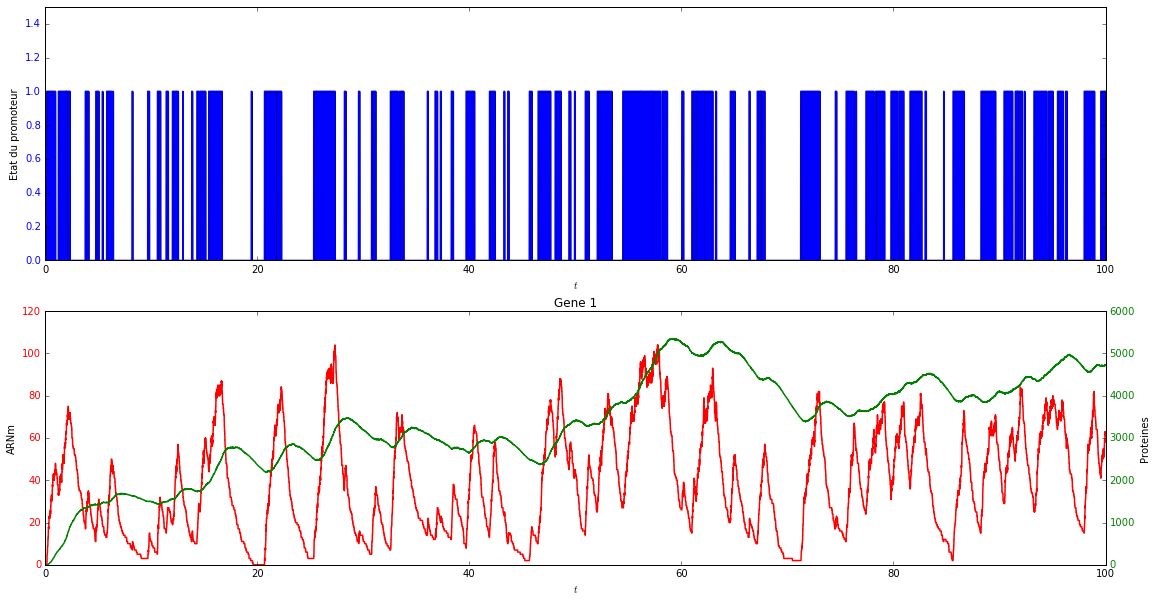

In [33]:
Gene().run(t_final=100).plot()
plt.show()

## Simple Switch 

Le simple switch nécessite 2 gènes, et les protéines de chacun des gènes exercent une action répressive sur le promoteur de l'autre gène. Ceci est implementé en modifiant la valeur de $k_{off}$ proportionnellement à la concentration en protéines répressives.  

### Définition de la classe MultipleSwitch:

In [28]:
class MultipleSwitch(object):
    def __init__(self, nbr_gene=2, constitutive=True, interaction=False):
        self.genes = [Gene(constitutive, interaction) for _ in range(nbr_gene)]
        self.t = 0
        for i in range(nbr_gene-1):
            self.genes[i].is_repressed_by(self.genes[i+1])
            self.genes[i+1].is_repressed_by(self.genes[i])

    def run(self, t_final):
        while 1:
            vector_rate = []
            for gene in self.genes:
                vector_rate.extend(gene.vector_rate())
            rate = sum(vector_rate)
            self.t += reaction_time(rate)
            if self.t > t_final:
                for gene in self.genes:
                    gene.t = t_final
                    gene.store_current_state()
                break
            else:
                reaction = choose_reaction(vector_rate, rate)
                index = int(reaction / 6)
                self.genes[index].update_state(int(reaction % 6))
                for gene in self.genes:
                    gene.t = self.t
                    gene.store_current_state()
        return self

    def plot(self):
        fig = plt.figure()
        for k, gene in enumerate(self.genes):
            gene.plot(fig, k+1, len(self.genes))

Par ailleurs la valeur constitutive de $k_{off}$ (en l'absence de toute proteine repressive) peut être nulle ou pas selon le modèle choisi. Ci-dessous les 2 options sont étudiés.

### Figure 2. Simulation avec $k_{off}$ constitutif non nul

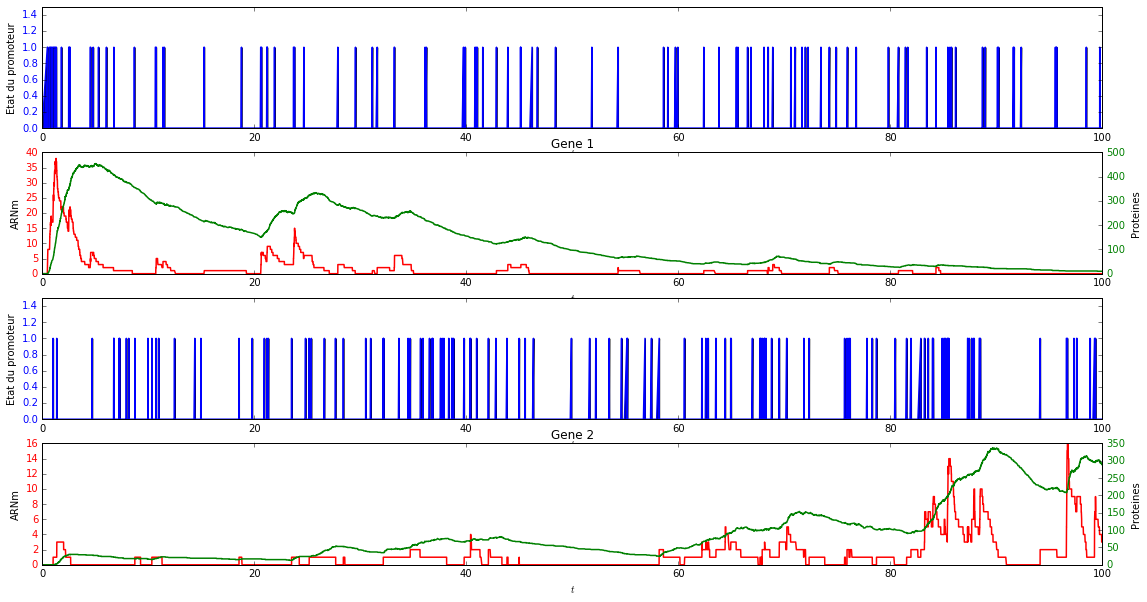

In [22]:
MultipleSwitch(2, constitutive=True).run(t_final=100).plot()
plt.show()

###  Figure 3. Simulation avec  $k_{off}$ constitutif nul

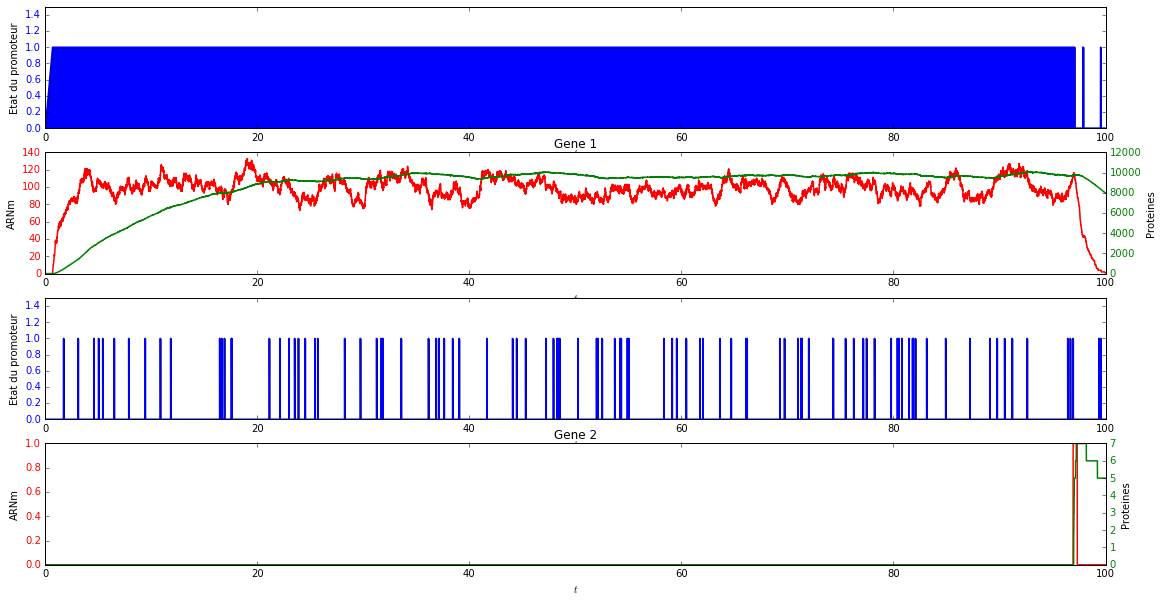

In [31]:
MultipleSwitch(2, constitutive=False).run(t_final=100).plot()
plt.show()

Si la valeur constitutive de $k_{off}$ de chacun des gènes est nulle (figure 3), alors un seul des gènes prend le dessus et l'autre ne pourra jamais être exprimé. En revanche si la valeur constitutive de $k_{off}$ de chacun des gènes est non nulle (figure 2), alors il y a aura au cours du temps inversion des inhibitions.

## Double Switch

Le double switch nécessite 3 gènes, et les protéines de chacun des gènes exercent une action répressive sur le promoteur des gènes voisins. Les protéines répressives peuvent agir de façon **indépendantes** sur $k_{off}$ ($k_{off}$ est proportionnel à la **somme** des concentration en protéines répressives) ou bien en **interactions** ($k_{off}$ est proportionnel au **produit** des concentrations en protéines répressives)

### Figure 4. Simulation sans interaction et $k_{off}$ constitutif non nul


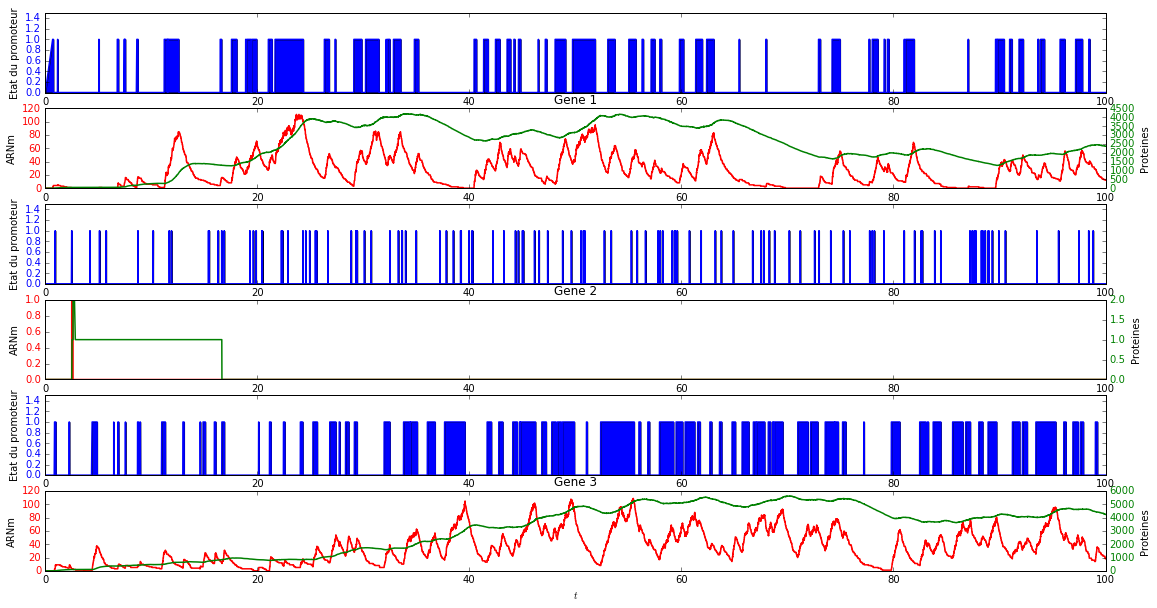

In [7]:
MultipleSwitch(3, constitutive=True, interaction=False).run(t_final=100).plot()
plt.show()

### Figure 5. Simulation avec interaction et $k_{off}$ constitutif non nul 

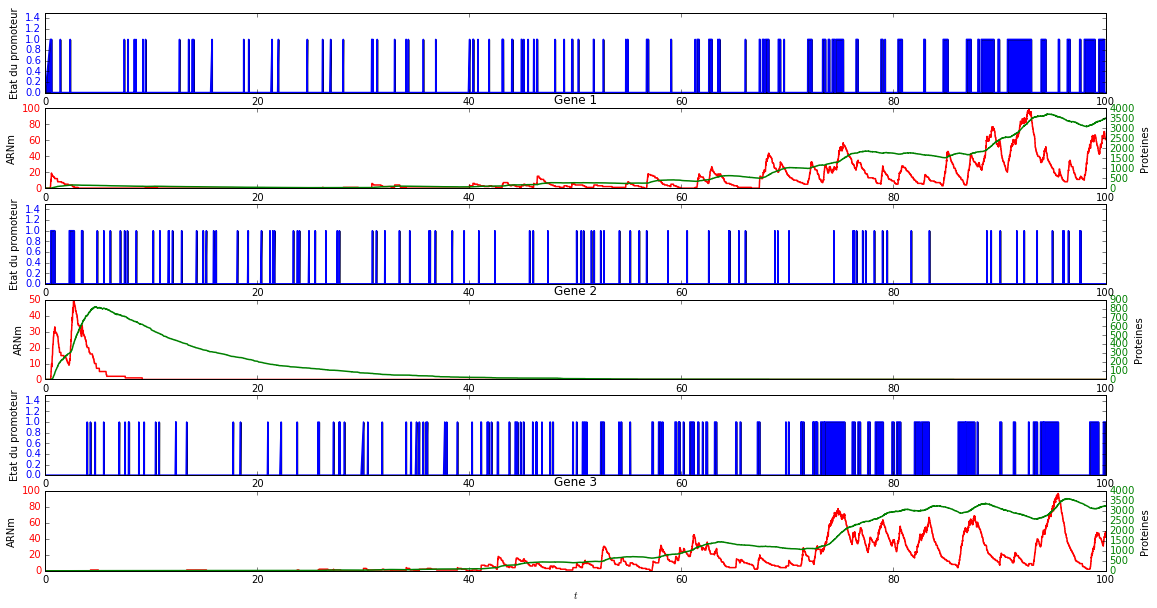

In [8]:
MultipleSwitch(3, constitutive=True, interaction=True).run(t_final=100).plot()
plt.show()

### Figure 6. Simulation sans interaction et $k_{off}$ constitutif nul 

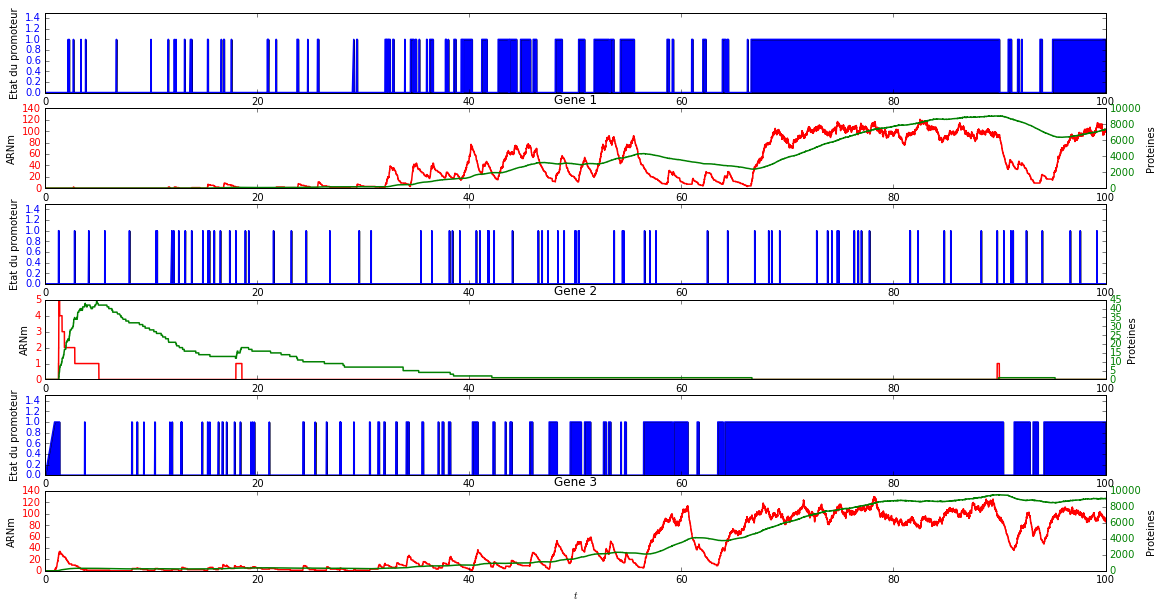

In [9]:
MultipleSwitch(3, constitutive=False, interaction=False).run(t_final=100).plot()
plt.show()

### Figure 7. Simulation avec interaction et $k_{off}$ constitutif nul

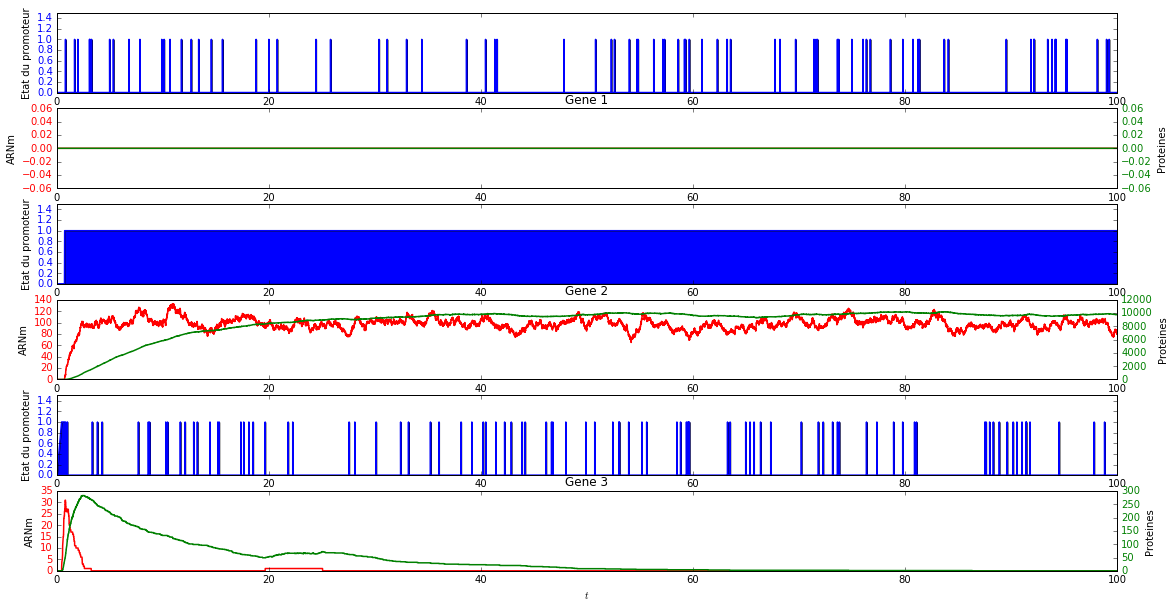

In [10]:
MultipleSwitch(3, constitutive=False, interaction=True).run(t_final=100).plot()
plt.show()

Avec (figure 5 et 7) ou sans interaction (figure 4 et 6), on observe que si un gene est actif, alors ces voisins sont inhibés. Cela est encore plus vraie lorsque la valeur constitutive de $k_{off}$ de chacun des gènes est nulle (figure 6 et 7).

### Figure 8. Triple switch (pour le fun)

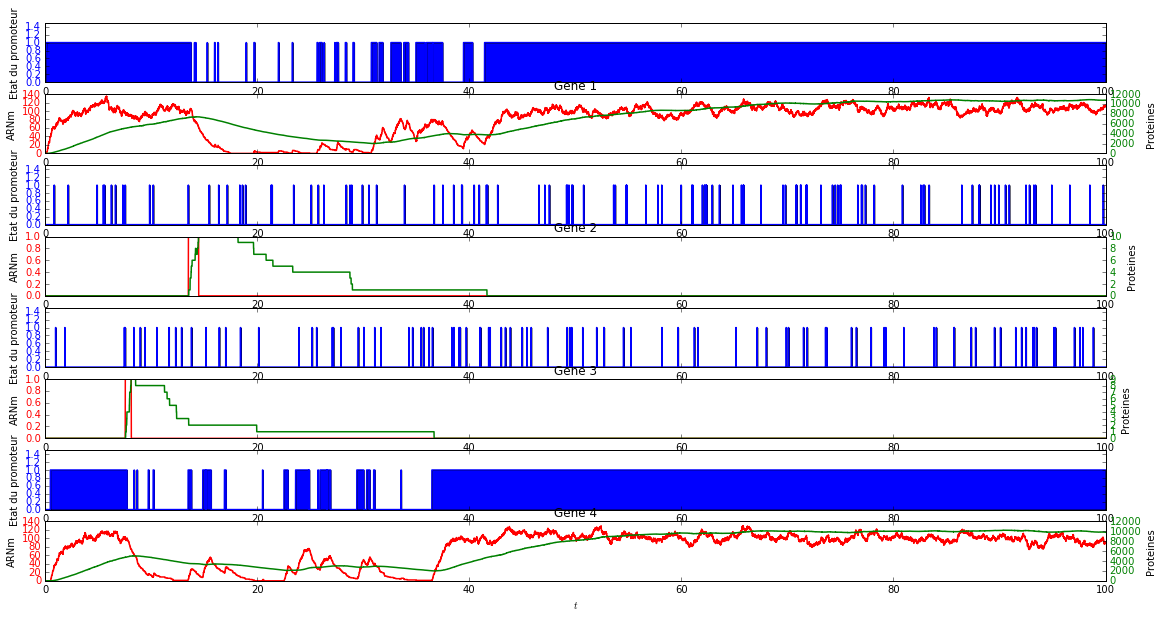

In [15]:
MultipleSwitch(4, constitutive=False, interaction=False).run(t_final=100).plot()
plt.show()

### Figure 9. Quadruple switch (encore plus de fun)

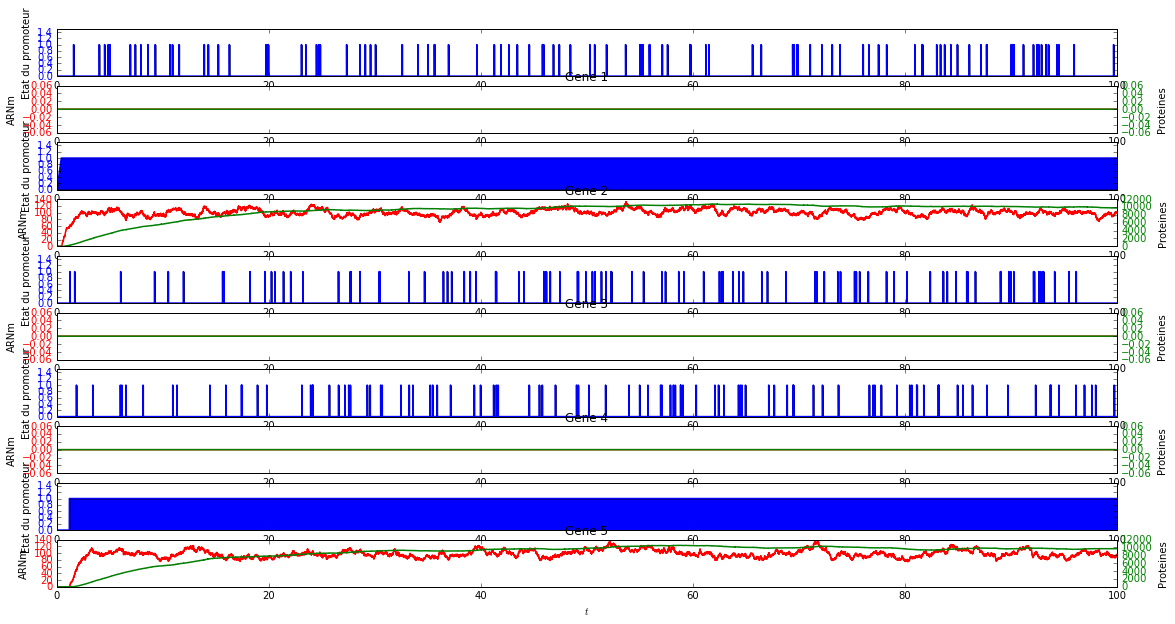

In [12]:
MultipleSwitch(5, constitutive=False, interaction=False).run(t_final=100).plot()
plt.show()

### Figure 10. Octuple switch (parce qu'on aime bien faire chauffer les ordinateurs)

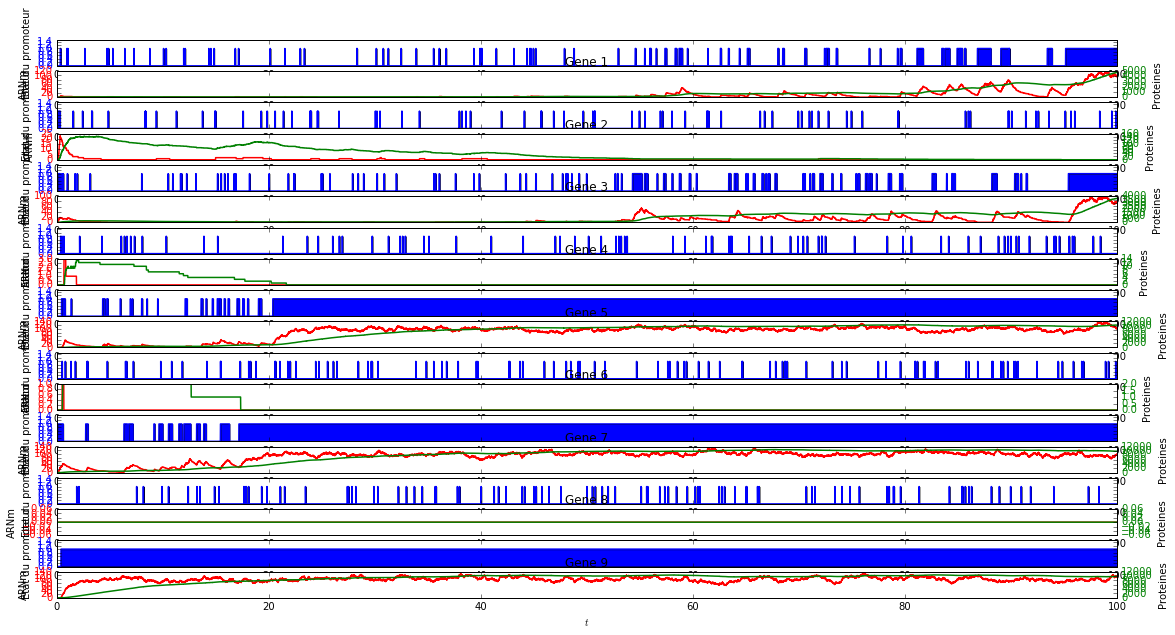

In [13]:
MultipleSwitch(9, constitutive=False, interaction=False).run(t_final=100).plot()
plt.show()

De même, on observe que si un gene est actif, alors ces voisins sont inhibés (figure 8, 9 et 10).